In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [2]:
import os
import sys

In [3]:
# chaging directory

In [4]:
root, *_ = !pwd

In [5]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd

In [6]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [7]:
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [9]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb']

In [10]:
train_data = pd.read_csv(RAW_PATH / 'train.csv', parse_dates=['date'])
train_data = train_data.set_index('date')

In [11]:
train_data.head()

,nextDayPlayerEngagement,games,rosters,playerBoxScores,teamBoxScores,transactions,standings,awards,events,playerTwitterFollowers,teamTwitterFollowers
date,,,,,,,,,,,
2018-01-01,"[{""engagementMetricsDate"":""2018-01-02"",""player...",NaN,"[{""playerId"":400121,""gameDate"":""2018-01-01"",""t...",NaN,NaN,"[{""transactionId"":340732,""playerId"":547348,""pl...",NaN,NaN,NaN,"[{""date"":""2018-01-01"",""playerId"":545361,""playe...","[{""date"":""2018-01-01"",""teamId"":147,""teamName"":..."
2018-01-02,"[{""engagementMetricsDate"":""2018-01-03"",""player...",NaN,"[{""playerId"":134181,""gameDate"":""2018-01-02"",""t...",NaN,NaN,"[{""transactionId"":339458,""playerId"":621173,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-03,"[{""engagementMetricsDate"":""2018-01-04"",""player...",NaN,"[{""playerId"":425492,""gameDate"":""2018-01-03"",""t...",NaN,NaN,"[{""transactionId"":347527,""playerId"":572389,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-04,"[{""engagementMetricsDate"":""2018-01-05"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-04"",""t...",NaN,NaN,"[{""transactionId"":339549,""playerId"":545343,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-05,"[{""engagementMetricsDate"":""2018-01-06"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-05"",""t...",NaN,NaN,"[{""transactionId"":341195,""playerId"":628336,""pl...",NaN,NaN,NaN,NaN,NaN


In [12]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd


def pandas_hstack(Xs):
    return pd.concat([X.reset_index(drop=True) for X in Xs], axis=1)

class PdColumnTransformer(ColumnTransformer):
    def _hstack(self, Xs):
        return pandas_hstack(Xs)

class PdFeatureUnion(FeatureUnion):
    def _hstack(self, Xs):
        return pandas_hstack(Xs)

def unpack_json(json_str):
    return np.nan if pd.isna(json_str) else pd.read_json(json_str)

def unpack_column(series: pd.DataFrame) -> pd.DataFrame:
    def _unpack_row(index, row):
        out_df = unpack_json(row)
        out_df = out_df.assign(date=index)
        return out_df
    
    return pd.concat([_unpack_row(index, row)
                      for index, row in series.iteritems()
                      if pd.notna(row)], ignore_index=True)

def make_unpack_tmf(column_name):
    return PdColumnTransformer([(column_name, FunctionTransformer(unpack_column), column_name,
                                        )])

### missing data 

Binary columns will have null values as well as zeroes. Zeroes will occur if a player had an opportunity to do something, but did not. Nulls will occur if a player never had the opportunity to do something (for example: a player who does not pitch on a given day cannot possibly pitch a shutout - therefore a null value is expected)

In [12]:
train_data.isna().mean()

date                       0.000000
nextDayPlayerEngagement    0.000000
games                      0.474507
rosters                    0.000000
playerBoxScores            0.557566
teamBoxScores              0.557566
transactions               0.092928
standings                  0.563322
awards                     0.758224
events                     0.559211
playerTwitterFollowers     0.967105
teamTwitterFollowers       0.967105
dtype: float64

### dates 

In [13]:
start_date, end_date = train_data['date'].agg(('min', 'max'))
start_date, end_date, end_date-start_date

(Timestamp('2018-01-01 00:00:00'),
 Timestamp('2021-04-30 00:00:00'),
 Timedelta('1215 days 00:00:00'))

In [14]:
date_count = train_data['date'].value_counts()
np.unique(date_count), len(date_count)# there is only one date

(array([1]), 1216)

### target 

In [15]:
target_name = 'nextDayPlayerEngagement'

In [16]:
raw_target = train_data[target_name]

In [17]:
row = raw_target[0] # each row is a list of json files

In [18]:
len(row) # number of json files, let see if this number is constant

308069

In [19]:
lenght_json = list(map(len, raw_target.apply(lambda x: x.split('},'))))

In [20]:
lenght_json #each day has the same number of ids, at least in the target

[2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,
 2061,

In [21]:
# transforming

In [25]:
unpack_target_tmf = PdColumnTransformer([('target', FunctionTransformer(unpack_column), 'nextDayPlayerEngagement',
                                        )])

In [26]:
unpack_target_tmf

PdColumnTransformer(transformers=[('target',
                                   FunctionTransformer(func=<function unpack_column at 0x7f0d2ab69430>),
                                   'nextDayPlayerEngagement')])

In [27]:
%time target = unpack_target_tmf.fit_transform(train_data)

CPU times: user 19.6 s, sys: 335 ms, total: 19.9 s
Wall time: 19.9 s


In [29]:
target.drop('engagementMetricsDate', axis=1, inplace=True)

In [30]:
target.head()

,playerId,target1,target2,target3,target4,date
0,628317,0.011167,4.474708,0.005168,5.735294,2018-01-01
1,547989,0.042993,5.593385,0.045033,2.794118,2018-01-01
2,519317,0.974327,56.177043,13.693746,64.166667,2018-01-01
3,607625,0.006700,2.675097,0.005168,1.862745,2018-01-01
4,592547,0.001117,0.632296,0.002953,0.931373,2018-01-01


In [29]:
target_names = target.columns.drop(['date', 'playerId'])

In [30]:
mean_target = target.groupby('date')[target_names].mean().reset_index()

<Figure size 864x504 with 0 Axes>

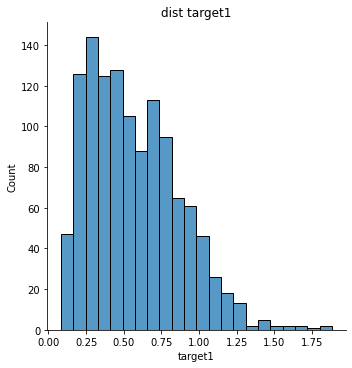

<Figure size 864x504 with 0 Axes>

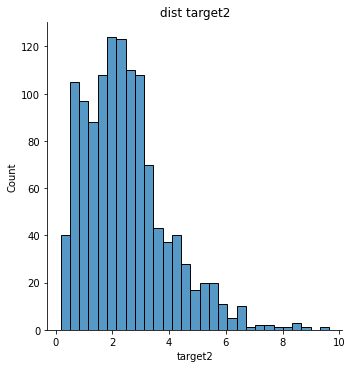

<Figure size 864x504 with 0 Axes>

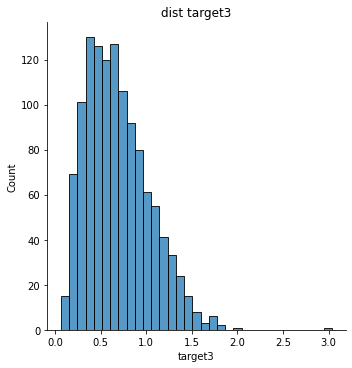

<Figure size 864x504 with 0 Axes>

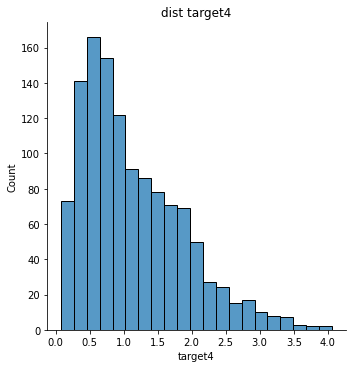

In [31]:
for name, values in mean_target[target_names].items():
    plt.figure(figsize=(12, 7))
    sns.displot(values);
    plt.title(f'dist {name}');

In [32]:
def plot_freq_dist(data, freq, target, ncols: int = 3):
    freq_values = getattr(data['date'].dt, freq)
    nunique = freq_values.nunique()
    nrows = nunique // ncols
    if nunique % nrows > 0:
        nrows += 1

    f, ax =plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6), sharex=True, sharey=True)
    for e, (freq_unit, freq_data) in enumerate(data.groupby(freq_values), start=0):
        row, col = e//ncols, e%ncols
        ax_plot = ax[row][col]
        sns.histplot(freq_data[target], ax=ax_plot);
        ax_plot.set_title(f'{freq}, value = {freq_unit}, dist {target}');

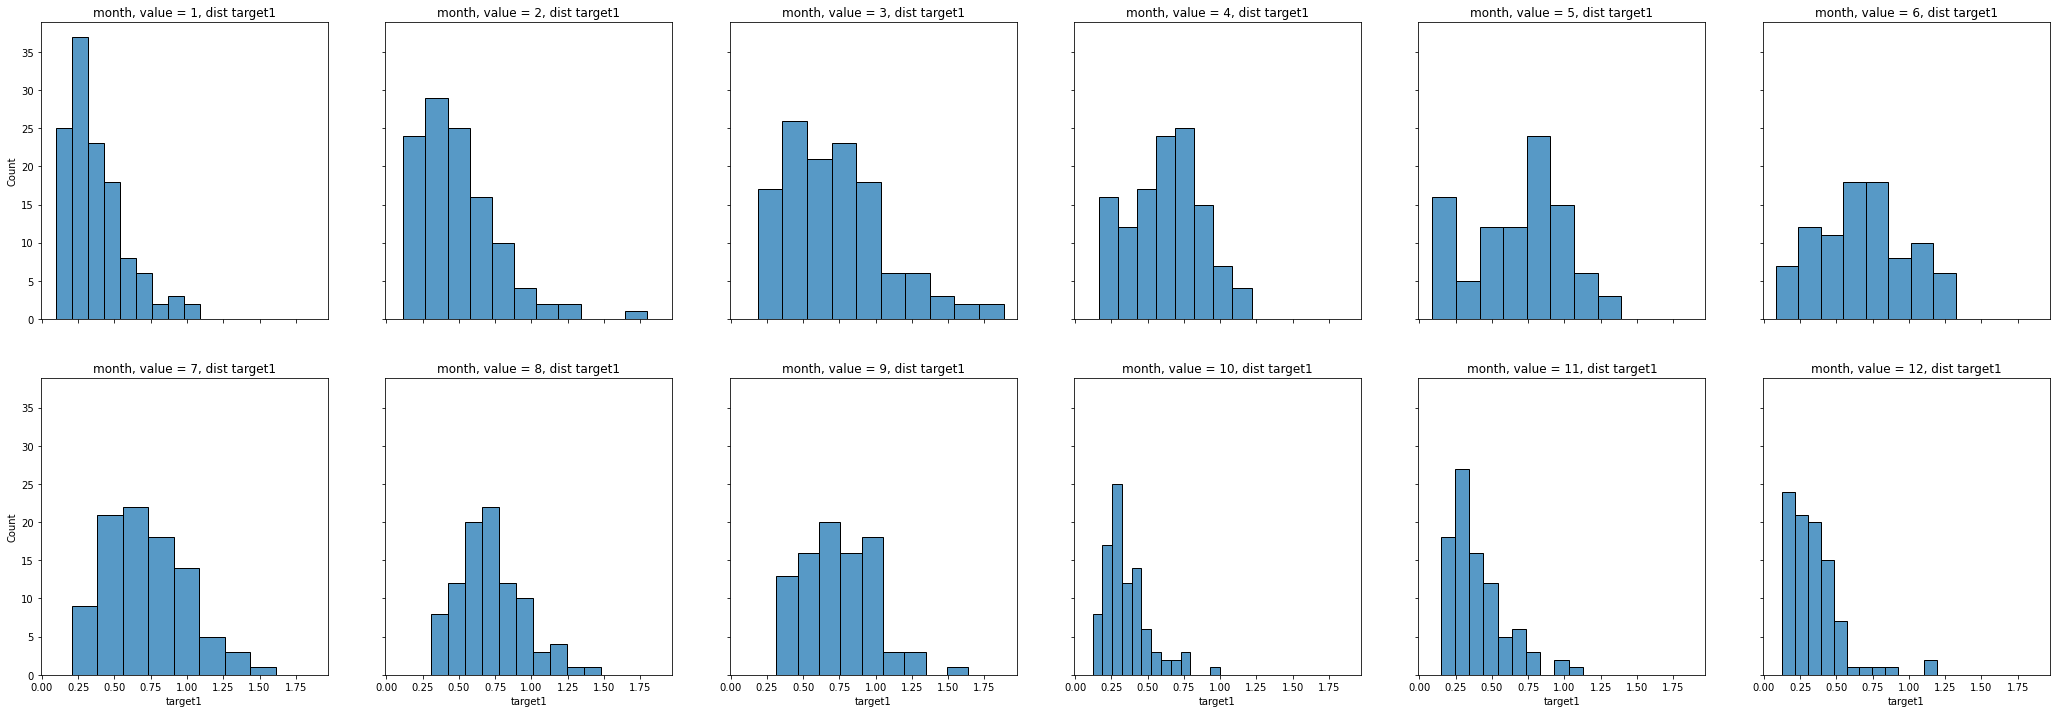

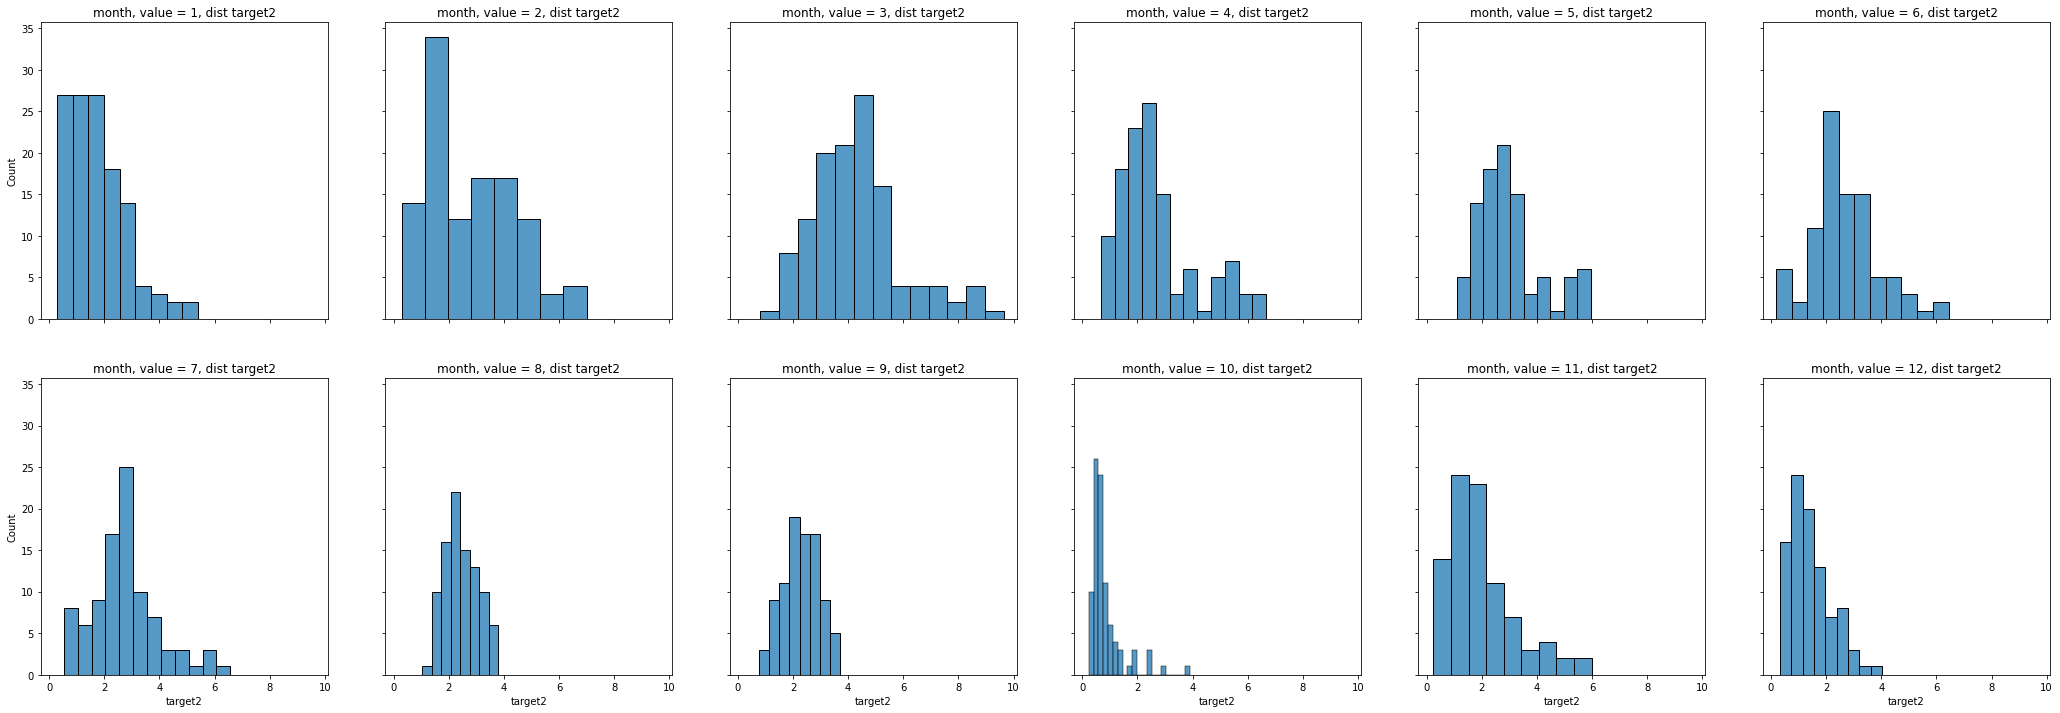

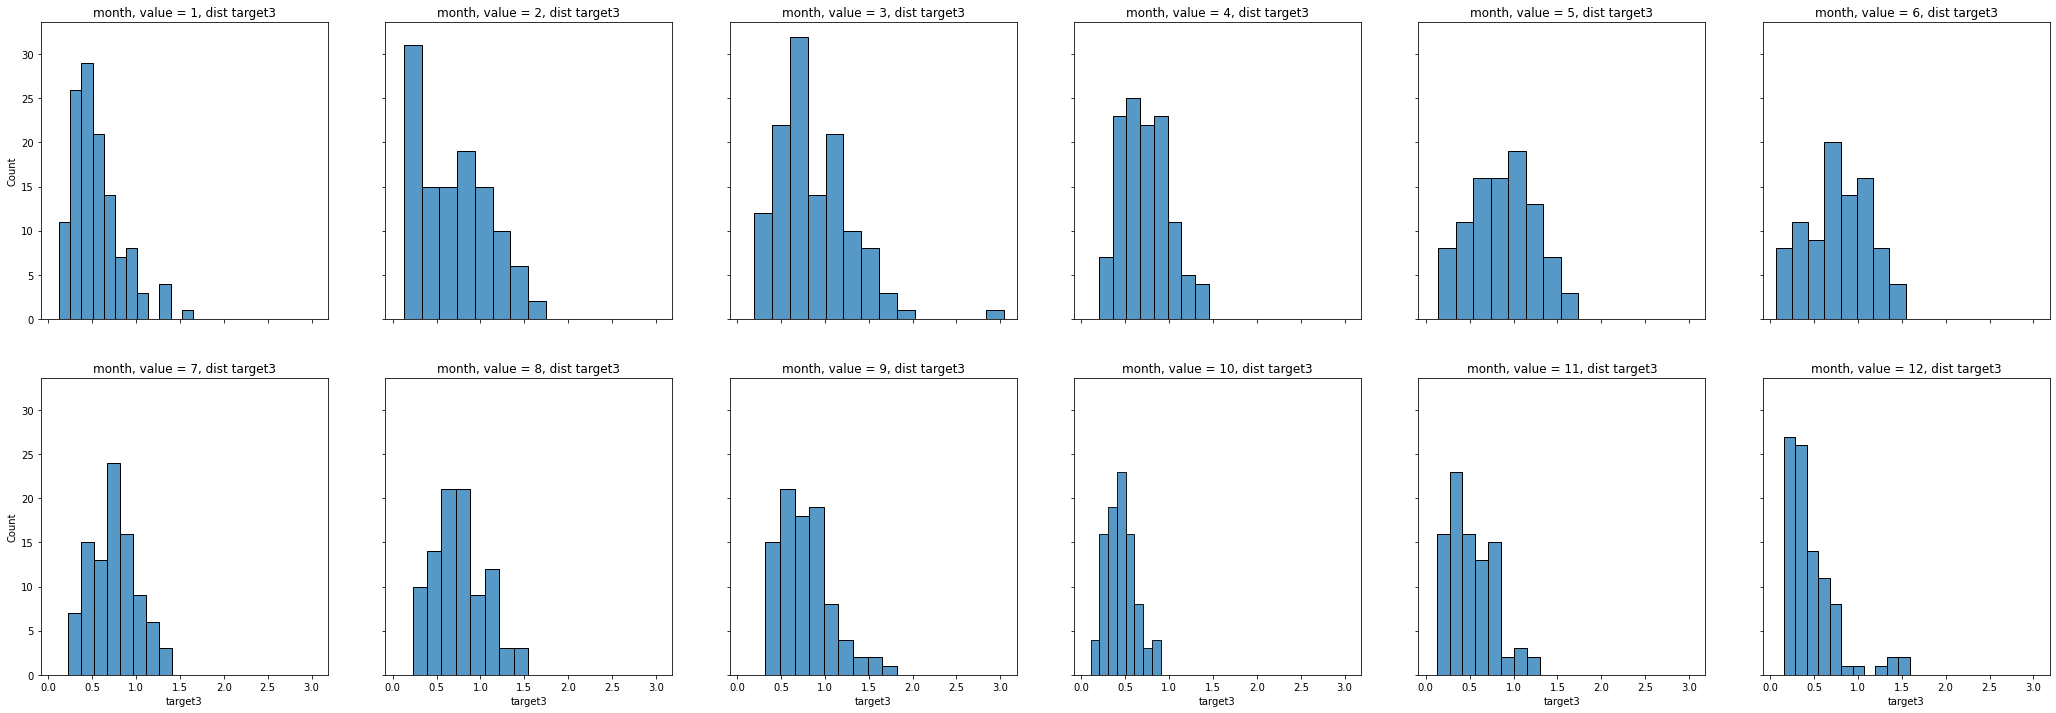

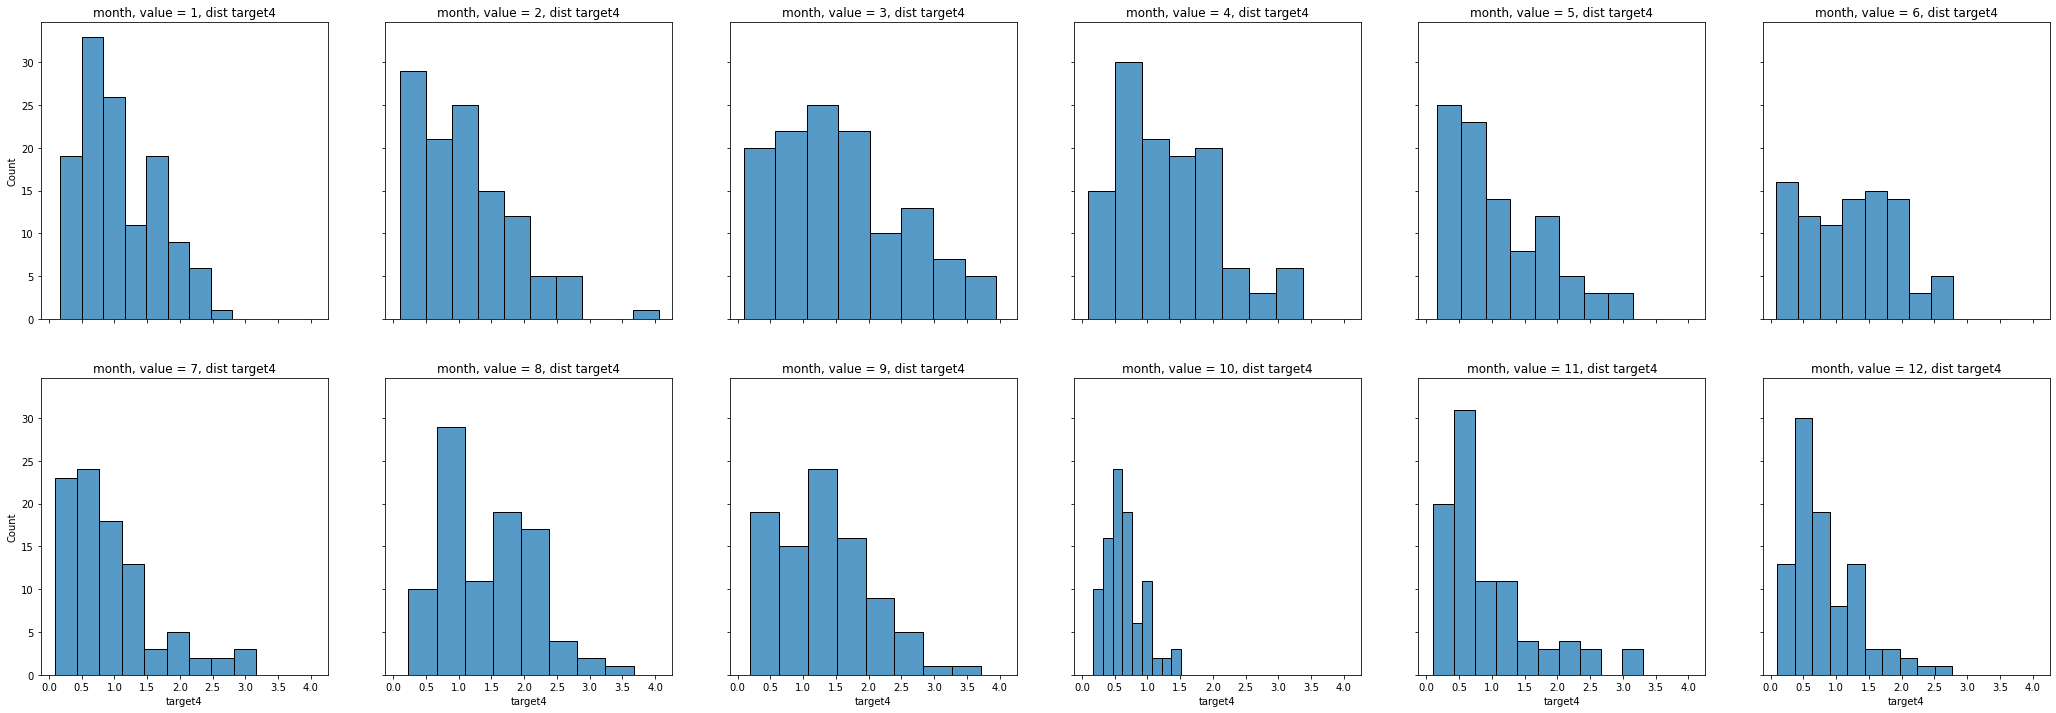

In [34]:
for _target_name in target_names:
    plot_freq_dist(mean_target, 'month', _target_name, ncols=6)

<AxesSubplot:>

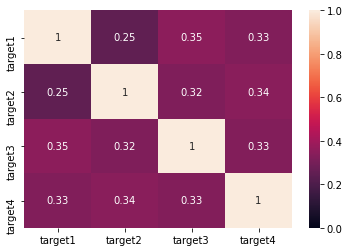

In [35]:
sns.heatmap(mean_target.corr().abs(), annot=True, vmin=0, vmax=1)

In [36]:
# well come back to see more

###  playerBoxScores

In [82]:
### this data is too hard to use yet, so we will used later 

In [31]:
column_name = 'playerBoxScores'

In [32]:
unpack_boxscores = PdColumnTransformer([('BoxScores', FunctionTransformer(unpack_column), 'playerBoxScores',
                                        )])

In [33]:
unpack_boxscores

PdColumnTransformer(transformers=[('BoxScores',
                                   FunctionTransformer(func=<function unpack_column at 0x7f0d2ab69430>),
                                   'playerBoxScores')])

In [34]:
%time boxscores = unpack_boxscores.fit_transform(train_data)

CPU times: user 18.9 s, sys: 197 ms, total: 19.1 s
Wall time: 19.1 s


In [58]:
boxscores.drop('gameDate', axis=1, inplace=True)

In [59]:
boxscores.head()

,home,gamePk,gameTimeUTC,teamId,teamName,playerId,playerName,jerseyNum,positionCode,positionName,...,sacBuntsPitching,sacFliesPitching,saves,holds,blownSaves,assists,putOuts,errors,chances,date
0,1,529418,2018-03-29T23:08:00Z,119,Los Angeles Dodgers,605131,Austin Barnes,15,12,Pinch Runner,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-29
1,1,529406,2018-03-29T20:00:00Z,139,Tampa Bay Rays,605480,Mallex Smith,0,7,Outfielder,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,2018-03-29
2,0,529416,2018-03-29T20:10:00Z,143,Philadelphia Phillies,546318,Odubel Herrera,37,8,Outfielder,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,2018-03-29
3,0,529412,2018-03-29T20:05:00Z,108,Los Angeles Angels,527043,Jefry Marte,19,3,First Base,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,2018-03-29
4,1,529408,2018-03-29T20:15:00Z,118,Kansas City Royals,449181,Paulo Orlando,16,8,Outfielder,...,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,2.0,2018-03-29


In [76]:
boxscores.groupby(['date', 'playerId']).agg(numGames = ('gamePk', 'nunique'))

numGames
date       playerId          
2018-03-29 134181           1
           400085           1
           400284           1
           405395           1
           407822           1
...                       ...
2021-04-30 676831           1
           676840           1
           676969           1
           683734           1
           685503           1

[182950 rows x 1 columns]

In [53]:
pd.options.display.max_rows = 120
boxscores.isna().mean().sort_values(ascending=False)

flyOutsPitching                 0.848097
blownSaves                      0.755050
holds                           0.755050
saves                           0.755050
winsPitching                    0.738906
lossesPitching                  0.737539
triplesPitching                 0.701967
hitsPitching                    0.701967
intentionalWalksPitching        0.701967
baseOnBallsPitching             0.701967
strikeOutsPitching              0.701967
homeRunsPitching                0.701967
groundOutsPitching              0.701967
doublesPitching                 0.701967
runsPitching                    0.701967
atBatsPitching                  0.701967
airOutsPitching                 0.701967
catchersInterferencePitching    0.701967
shutoutsPitching                0.701967
hitByPitchPitching              0.701967
stolenBasesPitching             0.701967
caughtStealingPitching          0.701967
strikes                         0.701967
gamesFinishedPitching           0.701967
rbiPitching     

In [80]:
lenght_json = list(map(len, train_data[column_name].dropna().apply(lambda x: x.split('},'))))

### standings

In [187]:
column_name = 'standings'

In [188]:
unpack_standings = make_unpack_tmf(column_name)

In [189]:
unpack_standings

PdColumnTransformer(transformers=[('standings',
                                   FunctionTransformer(func=<function unpack_column at 0x7f0d2ab69430>),
                                   'standings')])

In [190]:
train_data[column_name].isna().mean()

0.5633223684210527

In [97]:
%time standings = unpack_standings.fit_transform(train_data)

CPU times: user 7.68 s, sys: 18.6 ms, total: 7.7 s
Wall time: 7.67 s


In [191]:
standings.columns

Index(['season', 'gameDate', 'divisionId', 'teamId', 'teamName', 'streakCode',
       'divisionRank', 'leagueRank', 'wildCardRank', 'leagueGamesBack',
       'sportGamesBack', 'divisionGamesBack', 'wins', 'losses', 'pct',
       'runsAllowed', 'runsScored', 'divisionChamp', 'divisionLeader',
       'wildCardLeader', 'eliminationNumber', 'wildCardEliminationNumber',
       'homeWins', 'homeLosses', 'awayWins', 'awayLosses', 'lastTenWins',
       'lastTenLosses', 'extraInningWins', 'extraInningLosses', 'oneRunWins',
       'oneRunLosses', 'dayWins', 'dayLosses', 'nightWins', 'nightLosses',
       'grassWins', 'grassLosses', 'turfWins', 'turfLosses', 'divWins',
       'divLosses', 'alWins', 'alLosses', 'nlWins', 'nlLosses', 'xWinLossPct',
       'date'],
      dtype='object')

In [194]:
standings.isna().mean()

season                       0.000000
gameDate                     0.000000
divisionId                   0.000000
teamId                       0.000000
teamName                     0.000000
streakCode                   0.006089
divisionRank                 0.000000
leagueRank                   0.000000
wildCardRank                 0.214313
leagueGamesBack              0.000000
sportGamesBack               0.000000
divisionGamesBack            0.000000
wins                         0.000000
losses                       0.000000
pct                          0.000000
runsAllowed                  0.000000
runsScored                   0.000000
divisionChamp                0.000000
divisionLeader               0.000000
wildCardLeader               0.847583
eliminationNumber            0.000000
wildCardEliminationNumber    0.128814
homeWins                     0.000000
homeLosses                   0.000000
awayWins                     0.000000
awayLosses                   0.000000
lastTenWins 

In [13]:
def get_feature_by_dtype(df: pd.DataFrame, dtype: np.dtype):
    return [feature for feature, value in df.items()
            if value.dtype == dtype]

def standing_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    def _streak(df: pd.DataFrame):
        df['streakCode'] = df['streakCode'].fillna('W0')
        winning_idx = df['streakCode'].str.startswith('W')
        game_streak = df['streakCode'].apply(lambda x: x[1:]).astype(np.float32)        
        # double column
#         df.loc[winning_idx, 'winStreak'] = streak[winning_idx]
#         df.loc[~winning_idx, 'loseStreak'] = streak[~winning_idx]
#         df.fillna(0, subset=['winStreak', 'loseStreak'], inplace=True)
        # one column
        df['gameStreak'] = game_streak * np.where(winning_idx, 1, -1)
        
        df.drop('streakCode', axis=1, inplace=True)
        return df

    # streak
    df = _streak(df)
    # min value set to 0
    df.loc[:, 'divisionRank'] -= 1
    # normalize from 0 to 1
    df.loc[:, 'leagueRank'] /= 15
    # normalize from 0 to 1 and set nan values to 0.5
    df.loc[:, 'wildCardRank'] = np.where(pd.notna(df['wildCardRank']),
                                  df['wildCardRank'] / 15,
                                  0.5)

    # columns with nan as - or none
    nan_as_tokens = ['leagueGamesBack',
                  'sportGamesBack',
                  'divisionGamesBack',
                  'eliminationNumber',
                  'wildCardEliminationNumber',
                  'wildCardLeader']
    df.loc[:, nan_as_tokens] = df.loc[:, nan_as_tokens].replace({'-': np.nan, None: np.nan})

    # games back
    games_back_cols = ['leagueGamesBack', 'divisionGamesBack']
    # filling nan values as 0
    df.loc[:, games_back_cols] = df[games_back_cols].astype(np.float32).fillna(0)
    # sportGamesBack == leagueGamesBack, removing redundancy
    df.drop('sportGamesBack', axis=1, inplace=True)

    
    # elimination games,  for the moment lets fill na with -1
    elimination_cols = ['eliminationNumber',
                        'wildCardEliminationNumber']
    df.loc[:, elimination_cols] = (df.loc[:, elimination_cols].replace({'E': -1}).
                                   astype(np.float32).fillna(-1))
    
    # to boolean and fill na with false
    df.loc[:, 'wildCardLeader'] = df['wildCardLeader'].fillna(False).astype(np.bool_)
    
    # boolean to float32
    boolean_features = get_feature_by_dtype(df, np.bool_)
    df.loc[:, boolean_features] = df[boolean_features].astype(np.float32)
    
    # fillna with -1
    al_nl_cols = ['alWins', 'alLosses', 'nlWins', 'nlLosses']
    df.loc[:, al_nl_cols] = df[al_nl_cols].fillna(-1)
    
    # dropping gameDate 
    df.drop('gameDate', axis=1, inplace=True)
    return df

In [14]:
standing_pipeline = Pipeline([('unpack', make_unpack_tmf('standings')),
                              ('preprocessing', FunctionTransformer(standing_preprocessing))])

In [15]:
standing_pipeline

Pipeline(steps=[('unpack',
                 PdColumnTransformer(transformers=[('standings',
                                                    FunctionTransformer(func=<function unpack_column at 0x7f5eb54231f0>),
                                                    'standings')])),
                ('preprocessing',
                 FunctionTransformer(func=<function standing_preprocessing at 0x7f5eb5944670>))])

In [16]:
%%time
standings = standing_pipeline.fit_transform(train_data) 

CPU times: user 10.4 s, sys: 27.4 ms, total: 10.4 s
Wall time: 10.4 s


In [17]:
standings.head()

,season,gameDate,divisionId,teamId,teamName,divisionRank,leagueRank,wildCardRank,leagueGamesBack,divisionGamesBack,...,turfLosses,divWins,divLosses,alWins,alLosses,nlWins,nlLosses,xWinLossPct,date,gameStreak
0,2018,2018-03-29,205,112,Chicago Cubs,0,0.200000,0.200000,0.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2018-03-29,1
1,2018,2018-03-29,204,146,Miami Marlins,3,0.800000,0.800000,1.0,1.0,...,0,0,0,0.0,1.0,0.0,1.0,0.0,2018-03-29,-1
2,2018,2018-03-29,204,121,New York Mets,1,0.333333,0.333333,0.0,0.0,...,0,0,0,1.0,0.0,1.0,0.0,1.0,2018-03-29,1
3,2018,2018-03-29,200,140,Texas Rangers,4,0.933333,0.866667,1.0,1.0,...,0,0,1,0.0,0.0,0.0,0.0,0.0,2018-03-29,-1
4,2018,2018-03-29,204,144,Atlanta Braves,0,0.133333,0.133333,0.0,0.0,...,0,1,0,0.0,0.0,0.0,0.0,0.0,2018-03-29,1
